# Aim

The aim of this practical session is to learn how to compute Mantel-Haenzsel summary rate ratios (RRs) and decide whether a summary measure is appropriate.

Throughout this session we will be analysing the Whitehall dataset. To read in the dataset, type:

In [1]:
library(tidyverse)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
library(haven)

In [3]:
whitehall_df <- read_dta("Data_files-20211113/WHITEHALL.dta")

# Defining follow-up information


Remember from Practical 1, before we are able to analyse follow-up data we must first define the dates of entry and exit into the study and the outcome (or ‘failure’) variable.

The outcome is the overall mortality all, whereas the time variables are timein and timeout. Both of these are expressed in days, so we need to set the scale to be 365.25 days to produce analyses in terms of person-years. Type:

In [4]:
whitehall_df_2 <- whitehall_df %>%
    mutate(followup_time = as.numeric(difftime(whitehall_df$timeout, 
                                               whitehall_df$timein, 
                                               units = "days")) / 365.25)

# Stratum-specific rates

To investigate how overall mortality varies according to age at entry to the study, we will recode age at entry into suitable groups,

In [5]:
whitehall_df_3 <- whitehall_df_2 %>%
    mutate(agecat = as.factor(case_when(agein < 45 ~ 0,
                              agein < 50 ~ 1,
                              agein < 55 ~ 2,
                              agein < 60 ~ 3,
                              agein < 65 ~ 4,
                              agein < 70 ~ 5,
                              TRUE ~ 999)))

We can use the `summarise` command to check the distribution of agecat. Type:

In [6]:
whitehall_df_3 %>%
    group_by(agecat) %>%
    summarise(n = n()) %>%
    mutate(percent = n / sum(n) * 100) %>%
    mutate(cum = cumsum(percent))

agecat,n,percent,cum
<fct>,<int>,<dbl>,<dbl>
0,277,16.517591,16.51759
1,445,26.535480,43.05307
2,362,21.586166,64.63924
3,340,20.274299,84.91354
4,215,12.820513,97.73405
5,38,2.265951,100.00000


Now, to examine how mortality rates change with age at entry we can use `Surv` from the `survival` package, and `SurvRate` from the `biostat3` package. Type:

In [7]:
library(survival)
library(biostat3)


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘biostat3’


The following object is masked from ‘package:survival’:

    colon




In [8]:
survRate(Surv(followup_time/1000, all) ~ agecat, 
         data=whitehall_df_3)

,agecat,tstop,event,rate,lower,upper
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agecat=0,0,4.9186177,24,4.879420,3.126336,7.260190
agecat=1,1,7.8548937,45,5.728913,4.178708,7.665736
agecat=2,2,6.0597504,82,13.531910,10.762330,16.796669
agecat=3,3,5.2820143,118,22.339962,18.491377,26.753340
agecat=4,4,3.0948473,101,32.634890,26.581654,39.654349
agecat=5,5,0.3952472,33,83.492055,57.472089,117.253887


The rates increase quite dramatically with each age category. This is best displayed in a graph. To produce a graph displaying the mortality trend with age at entry, use `ggplot`. However, if the rate ratios between successive categories are similar, the differences between successive log(rates) should be constant, therefore if we plot the rates on a log scale we should see a linear relationship with age. Type:

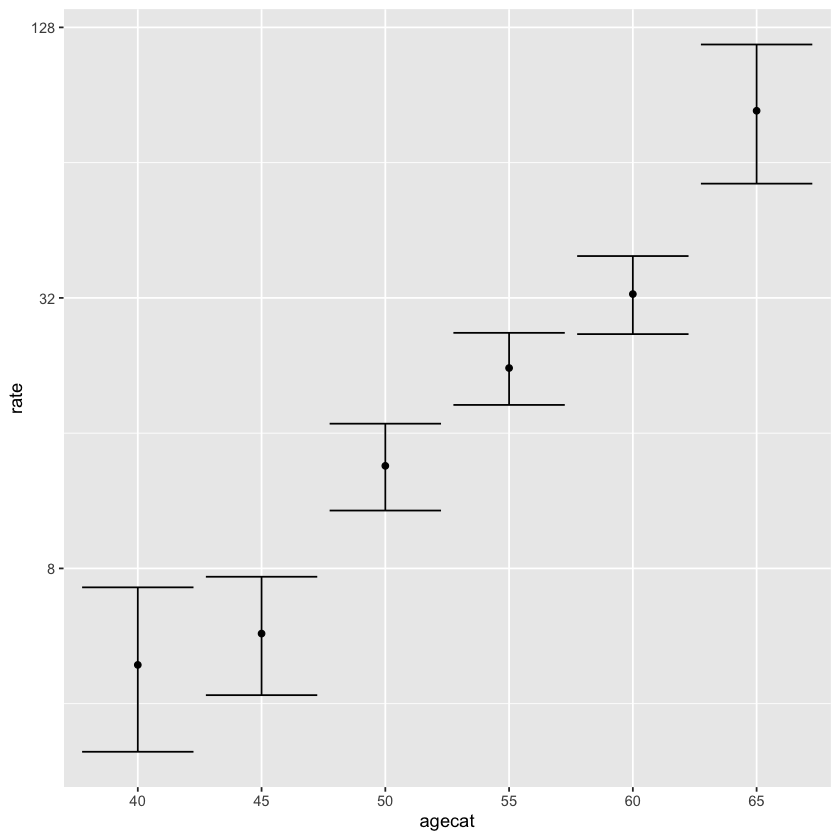

In [9]:
survRate(Surv(followup_time/1000, all) ~ agecat, 
         data=whitehall_df_3) %>%
    #Put the data into ggplot
    ggplot(aes(x = agecat, y = rate)) +
    #Plot the points
    geom_point() +
    #Add in error bars
    geom_errorbar(aes(ymin=lower, ymax=upper)) +
    #Transform the y axis into logarithmic
    scale_y_continuous(trans='log2') +
    #Specify x-axis label names
    scale_x_discrete(labels=seq(40,65,5))

We can see that the trend in rates across age is approximately linear on the log scale. This indicates that the rate ratio from one age group to the next is similar.

## Comparison between groups: rate ratios

To obtain rate ratios for the effect of age at entry with the youngest age group as the baseline we will use the `Surv` and `survRate`.

In [10]:
survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0)

,agecat,tstop,event,rate,lower,upper
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agecat=0,0,4.918618,24,4.87942,3.126336,7.26019


In [11]:
#Get the rate for agecat of 0
agecat_0 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0) %>%
    purrr::pluck("rate")

#Get the rate for agecat of 1
agecat_1 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 1) %>%
    purrr::pluck("rate")

#Get the ratio
agecat_1 / agecat_0

[1] 1.174097

In [12]:
#Get the rate for agecat of 0
agecat_0 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0) %>%
    purrr::pluck("rate")

#Get the rate for agecat of 2
agecat_2 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 2) %>%
    purrr::pluck("rate")

#Get the ratio
agecat_2 / agecat_0

[1] 2.773262

In [13]:
#Get the rate for agecat of 0
agecat_0 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0) %>%
    purrr::pluck("rate")

#Get the rate for agecat of 3
agecat_3 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 3) %>%
    purrr::pluck("rate")

#Get the ratio
agecat_3 / agecat_0

[1] 4.578406

In [14]:
#Get the rate for agecat of 0
agecat_0 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0) %>%
    purrr::pluck("rate")

#Get the rate for agecat of 4
agecat_4 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 4) %>%
    purrr::pluck("rate")

#Get the ratio
agecat_4 / agecat_0

[1] 6.688273

In [15]:
#Get the rate for agecat of 0
agecat_0 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 0) %>%
    purrr::pluck("rate")

#Get the rate for agecat of 5
agecat_5 <- survRate(Surv(followup_time/1000, all) ~ agecat, data=whitehall_df_3) %>%
    filter(agecat == 5) %>%
    purrr::pluck("rate")

#Get the ratio
agecat_5 / agecat_0

[1] 17.11106

It is clear that the rate ratios for consecutive age-groups versus the youngest age-group (baseline) increase with age.

The rate for the 45-49-year age-group is 1.17 times that of the 40-44 year age-group; 

The rate for the 50-54-year age-group is 2.77 times that of the 40-44 year age-group; 

The rate for the 55-59-year age-group is 4.58 times that of the 40-44 year age-group; and so on.

## Stratified estimates for the exposure of interest

Let’s say the main exposure of interest is grade of employment (coded: 1 = high grade, 2 = low grade). We will examine the all-cause mortality rates for low and high grades of employment, then estimate the rate ratio for low-grade employees versus high-grade employees.

In [16]:
survRate(Surv(followup_time/1000, all) ~ grade, 
         data=whitehall_df_3)

,grade,tstop,event,rate,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
grade=1,1,20.339787,221,10.8654,9.480013,12.39630
grade=2,2,7.265584,182,25.0496,21.542406,28.96505


In [17]:
#Get the rate for grade of 1
grade_1 <- survRate(Surv(followup_time/1000, all) ~ grade, 
                    data=whitehall_df_3) %>%
    filter(grade == 1) %>%
    purrr::pluck("rate")

#Get the rate for grade of 2
grade_2 <- survRate(Surv(followup_time/1000, all) ~ grade, 
                    data=whitehall_df_3) %>%
    filter(grade == 2) %>%
    purrr::pluck("rate")

#Get the ratio
grade_2 / grade_1

[1] 2.305446

To assess for potential confounding or effect modification by age at entry on the effect of employment grade use stmh with grade, stratified by agecat. Type:

In [18]:
#Get the rate for grade of 1
grade_1 <- survRate(Surv(followup_time/1000, all) ~ grade + agecat, data=whitehall_df_3) %>%
    filter(grade == 1) %>%
    purrr::pluck("rate")

#Get the rate for grade of 2
grade_2 <- survRate(Surv(followup_time/1000, all) ~ grade + agecat, data=whitehall_df_3) %>%
    filter(grade == 2) %>%
    purrr::pluck("rate")

#Get the ratios
tibble(survRate(Surv(followup_time/1000, all) ~ grade + agecat, data=whitehall_df_3) %>%
       filter(grade == 1) %>% 
       dplyr::select("agecat"), 
       "rate ratio" = grade_2 / grade_1)

agecat,rate ratio
<fct>,<dbl>
0,1.219251
1,1.359850
2,1.920887
3,1.433275
4,1.213287
5,1.399100


R can't give us rate ratios but can do odds ratios with `epiDisplay`'s `cc` for crude odds ratios and `mhor` for adjusted

In [19]:
library(epiDisplay)

Loading required package: foreign

Loading required package: nnet


Attaching package: ‘epiDisplay’


The following object is masked from ‘package:ggplot2’:

    alpha




In [20]:
cc(whitehall_df_3$all, whitehall_df_3$grade,
              graph = FALSE)


                  whitehall_df_3$grade
whitehall_df_3$all    1    2 Total
             0      973  301  1274
             1      221  182   403
             Total 1194  483  1677

OR =  2.66 
95% CI =  2.1, 3.37  
Chi-squared = 69.24, 1 d.f., P value = 0
Fisher's exact test (2-sided) P value = 0 


In [21]:
mhor(whitehall_df_3$all, 
     whitehall_df_3$grade,
     whitehall_df_3$agecat, design = "cohort",
     graph = FALSE)


Stratified analysis by  Var3 
               OR lower lim. upper lim.  P value
Var3 0       1.20      0.283       3.90 0.760993
Var3 1       1.37      0.577       3.00 0.412133
Var3 2       2.16      1.216       3.79 0.005531
Var3 3       1.52      0.936       2.47 0.077315
Var3 4       1.26      0.711       2.25 0.412540
Var3 5       3.57      0.241      40.76 0.222687
M-H combined 1.56      1.200       2.03 0.000833

M-H Chi2(1) = 11.17 , P value = 0.001 
Homogeneity test, chi-squared 5 d.f. = 2.97 , P value = 0.705 



#### To examine whether the crude OR estimate for low grade, OR=2.66, is confounded by age at entry, we will examine the age-specific estimates. First we will assess whether there is any effect modification (also called ‘interaction’). The null hypothesis is ‘no effect modification’ and the large p-value (P=0.71) does not provide any evidence against the null hypothesis. Also, the values of the age-specific ORs are quite similar (they range from 1.2 to 3.57 with no evidence of a trend) therefore it is appropriate to summarise them using the Mantel-Haenszel estimate, OR=1.56 (95% CI 1.20 to 2.03). 

#### However, the results do show that the crude estimate of the effect of grade is strongly confounded by age at entry (ORcrude = 2.66, compared to RRM-H = 1.56).

# Review exercise

### 1) In order to analyse CHD mortality, set the time and the CHD mortality outcome variables with stset (remember that the time variables are timein and timeout, the outcome is chd, the identifier is id, and the scale should be set to years). Use the tab command on the chd variable to check that the number of deaths from CHD corresponds with the number given in the stset output.

 This is not needed in R

### 2) Recode age at entry into 5-year age-groups and investigate how CHD mortality varies according to age at entry to the study using strate.

In [22]:
survRate(Surv(followup_time/1000, chd) ~ agecat, 
         data=whitehall_df_3)

,agecat,tstop,event,rate,lower,upper
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agecat=0,0,4.9186177,11,2.236401,1.116403,4.001539
agecat=1,1,7.8548937,16,2.036947,1.164291,3.307874
agecat=2,2,6.0597504,34,5.610792,3.885637,7.840520
agecat=3,3,5.2820143,50,9.466086,7.025911,12.479854
agecat=4,4,3.0948473,32,10.339767,7.072393,14.596666
agecat=5,5,0.3952472,11,27.830685,13.892978,49.796783


Rates increase dramatically in older age brackets

### 3) Examine the CHD mortality rates for low and high grades of employment. Use the stmh command to estimate the rate ratio for low-grade employees versus high-grade employees.

In [23]:
survRate(Surv(followup_time/1000, chd) ~ grade, 
         data=whitehall_df_3)

,grade,tstop,event,rate,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
grade=1,1,20.339787,90,4.424825,3.558082,5.438861
grade=2,2,7.265584,64,8.808652,6.783736,11.248452


Rates for low-grade employees are almost double that for high-grade

### 4) Use stmh to examine the effect of grade, stratified by age at entry:

In [24]:
cc(whitehall_df_3$chd, whitehall_df_3$grade,
              graph = FALSE)


                  whitehall_df_3$grade
whitehall_df_3$chd    1    2 Total
             0     1104  419  1523
             1       90   64   154
             Total 1194  483  1677

OR =  1.87 
95% CI =  1.33, 2.63  
Chi-squared = 13.46, 1 d.f., P value = 0
Fisher's exact test (2-sided) P value = 0 


In [25]:
mhor(whitehall_df_3$chd, 
     whitehall_df_3$grade,
     whitehall_df_3$agecat, design = "cohort",
     graph = FALSE)


Stratified analysis by  Var3 
                OR lower lim. upper lim. P value
Var3 0       2.312     0.3781      10.20  0.2013
Var3 1       1.072     0.1913       4.03  1.0000
Var3 2       2.355     1.0463       5.18  0.0341
Var3 3       1.425     0.7363       2.73  0.2686
Var3 4       0.579     0.2499       1.32  0.1790
Var3 5       0.474     0.0635       3.95  0.3902
M-H combined 1.232     0.8610       1.76  0.2388

M-H Chi2(1) = 1.39 , P value = 0.239 
Homogeneity test, chi-squared 5 d.f. = 9.13 , P value = 0.104 



#### Is there any evidence of interaction between employment grade and age at entry? 

The crude OR of 1.87 is higher than the adjusted of OR 1.39 so perhaps some confounding.

#### Examine the result of the test for interaction. Is the effect of grade confounded by age at entry?

There is no clear trend and not strong evidence of confounding by age. 